# The Problem of Features and Deep Learning

Let's begin by recalling and slightly expanding the empirical risk minimization framework that we've developed throughout this course. In the simplest approach to empirical risk minimization, we began with a matrix of features $\mathbf{X} \in \mathbb{R}^{n\times p}$ and a vector of targets $\mathbf{y} \in \mathbb{R}^n$. We defined a linear score  $s =  \langle \mathbf{w}, \mathbf{x}\rangle$ which we interpreted as producing predictions of the value of $y$. We then defined a loss function $\ell: \mathbb{R}\times \mathbb{R} \rightarrow \mathbb{R}$ that told us the quality of the prediction $s$ by comparing it to a true target $y$. Our learning problem was to find $\mathbf{w}$ by minimizing the *empirical risk*: the mean (or sum) of the risk across all data points:  

$$
\DeclareMathOperator*{\argmin}{argmin}
\begin{aligned}
\hat{\mathbf{w}} &= \argmin_{\mathbf{w} \in \mathbb{R}^p} \frac{1}{n}\sum_{i = 1}^n \ell(s_i, y_i) \\ 
                 &= \argmin_{\mathbf{w} \in \mathbb{R}^p} \frac{1}{n}\sum_{i = 1}^n \ell(\langle \mathbf{w}, \mathbf{x}_i \rangle, y_i)\;. 
\end{aligned}
$$

At first, we solved this problem using gradient descent. However, we soon ran into an issue -- the linear score $s = \langle \mathbf{w}, \mathbf{x}\rangle$ is only capable of describing linear structures in the data. 

So far, we've addressed nonlinearity in two ways. First, we tried *manual feature engineering*. In manual feature engineering, we apply a feature map $\phi: \mathbb{R}^p \rightarrow \mathbb{R}^q$ to the rows of the data matrix $\mathbf{X}$ to produce a new matrix $\Phi(\mathbf{X})$:  

$$
\begin{aligned}
    \Phi(\mathbf{X}) \triangleq \left[\begin{matrix}\phi(\mathbf{x}_1) \\ \phi(\mathbf{x}_2) \\ \vdots \\ \phi(\mathbf{x}_n)\end{matrix}\right] 
\end{aligned}
$$

Our problem then became to solve the empirical risk minimization problem 

$$
\begin{aligned}
\hat{\mathbf{w}} &= \argmin_{\mathbf{w} \in \mathbb{R}^q} \frac{1}{n}\sum_{i = 1}^n \ell(\langle \mathbf{w}, \phi(\mathbf{x}_i) \rangle, y_i)\;, 
\end{aligned}
$${#eq-ERM}

where $\mathbf{w}$ had as many entries as the number of features which we generated using $\phi$. Later on, we saw that we could actually solve this problem in some cases using *kernel methods*, which allowed us to use complex feature maps without ever explicitly calculating them. A limitation of both manual feature engineering and kernel methods is that the practitioner needs to make a choice about what features to engineer or what kernels to use. For some data sets it might be relatively easy to make this choice, while for others it might be much harder. For extremely large data sets with very complex patterns, it may be very difficult to figure out what features will facilitate the learning task. 

Manual feature engineering and kernel methods were state-of-the-art for many machine learning tasks up until the advent of practical deep learning early in the 21st century. 

## The Computational Graph 


It will soon be very useful for us to start thinking about the operations underlying the computation of the loss in terms of a *computational graph*. In the computational graph, we break down each operation as an edge in the graph, storing the result of that operation in the nodes. 

For example, here's a high-level computational graph associated with the standard linear model in @eq-ERM with no feature maps: 

shows the loss

```{mermaid}
flowchart LR
  input[Data matrix X] --Matrix-vector\nmultiplication--> l3["Xw"]

  y[Targets y]        --Apply\nloss--> loss["ℓ(Xw, y)"]
  l3       --Apply\nloss--> loss 
  loss     --Compute\naverage-->L
```

If we wanted to apply a feature map $\phi$, we would need to incorporate one additional step in the computational graph: 

- has new edge and node to apply feature map 

```{mermaid}
flowchart LR
  input[Data matrix X] --Apply feature\nmap-->l1["Φ(X)"]
  l1                   --Matrix-vector\nmultiplication--> l3["Φ(X)w"]

  y[Targets y] --Apply\nloss--> loss["ℓ(Φ(X)w, y)"]
  l3           --Apply\nloss--> loss 
  loss         --Compute\naverage-->L
```


## Optimizing the Features

Here's a superficially simple question about @eq-ERM and its associated computational graph: what if we could learn both the weights $\mathbf{w}$ *and* the feature map $\phi$ simultaneously? That is, what if we could solve a problem like 

$$
\begin{aligned}
\hat{\mathbf{w}} &= \argmin_{\mathbf{w} \in \mathbb{R}^q, \color{blue}{\phi \in \mathcal{F}}} \frac{1}{n}\sum_{i = 1}^n \ell(\langle \mathbf{w}, \phi(\mathbf{x}_i) \rangle, y_i)\;, 
\end{aligned}
$${#eq-ERM-feature}


where $\mathcal{F}$ is some set of possible feature maps? 

In general, we have no hope of doing this -- there are simply too many possible feature maps. However, if we restrict the set $\mathcal{F}$ somewhat, then we may have some hope. 

In particular, let's choose a *nonlinear* function $\alpha: \mathbb{R} \rightarrow \mathbb{R}$ and a matrix $\mathbf{U} \in \mathbb{R}^{p \times q}$. We'll define our feature map $\phi$ by the formula $\phi(\mathbf{X}) = \alpha(\mathbf{X}\mathbf{U})$, where $\alpha$ is applied to each element of the matrix $\mathbf{X}\mathbf{U}$. We'll treat $\alpha$ as fixed but $\mathbf{U}$ as *learnable*. This turns our optimization problem into

- U is a matrix of new parameters (real numbers)

- nothing is convex, model probs stuck on local min. might not find global min. DL

$$
\begin{aligned}
\hat{\mathbf{w}} &= \argmin_{\mathbf{w} \in \mathbb{R}^q, \color{blue}{\mathbf{U} \in \mathbb{R}^{p \times q}}} \frac{1}{n}\sum_{i = 1}^n \ell(\langle \mathbf{w}, \alpha (\mathbf{x}_i \mathbf{U}) \rangle, y_i)\;. 
\end{aligned}
$${#eq-hidden-layer}

We now have an optimization problem with two sets of weights: the standard weights $\mathbf{w}$ and the *hidden weights* $\mathbf{U}$. @eq-hidden-layer defines the structure of a *shallow* neural network with a single hidden layer. 

The computational graph for this @eq-hidden-layer model now looks like this: 

```{mermaid}
flowchart LR
  input[Data matrix X] --Matrix\nmultiplication--> l1[XU]
  l1       --Nonlinearity--> l2["ɑ(XU)"]
  l2       --Matrix-vector\nmultiplication--> l3["ɑ(XU)w"]

  y[Targets y]        --Apply\nloss--> loss["ℓ(ɑ(XU)w, y)"]
  l3       --Apply\nloss--> loss 
  loss     --Compute\naverage-->L
```

### Model Layers

In this model, the matrix $\mathbf{U}$ is an example of a so-called *hidden parameter* or *hidden layer*. It's *hidden* because it's not involved in the final computation of scores (like $\mathbf{w}$) and it's also not part of the data input. If we were only looking at the inputs and final computational operations of the model, we wouldn't see $\mathbf{U}$ at all. We only see it when we look at the complete sequence of network operations. 

Importantly, we don't have to stop at one hidden layer. We could pick a *new* matrix $\mathbf{V} \in \mathbb{R}^{q \times r}$ and a possibly-different nonlinearity $\beta: \mathbb{R} \rightarrow \mathbb{R}$. Then, we could compute our feature map as 

$$
\begin{aligned}
    \phi(\mathbf{X}) = \beta(\alpha(\mathbf{X}\mathbf{U})\mathbf{V})\;.
\end{aligned}
$$

Then we would have two hidden layers and a longer chain in our computational graph.

A so-called *neural network* is a machine learning model that involves one or more arrays of hidden parameters. These models are also often called *deep learning* models -- their "depth" is in the unseen layers. 

## Implementation via Torch

Let's go ahead and implement some of these models in Torch. For our first implementation, we are going to focus on the simplest linear model without feature maps. The implementation of this model using Torch's standard neural network model is relatively similar to how we've implemented linear models in the past. The main difference is that instead of manually managing a weight vector `self.w`, instead we manage a `nn.Sequential` object that contains one or more layers of computation. Here, the `Linear` layer implements matrix multiplication and holds the analog of our vector `self.w`. Another difference is that we do not usually implement the loss in the model itself. Instead, we usually call a pre-implemented loss function during the training loop. 

To see this model in action, let's generate some data. 

In [1]:
import torch
from sklearn.datasets import make_moons, make_circles
from matplotlib import pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8-whitegrid')

X_train, y_train = make_moons(100, shuffle = True, noise = 0.2)
X_train = torch.tensor(X_train, dtype = torch.float)
y_train = torch.tensor(y_train)

X_val, y_val = make_moons(100, shuffle = True, noise = 0.2)
X_val = torch.tensor(X_val, dtype = torch.float)
y_val = torch.tensor(y_val)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#| code-fold: true
def plot_classification_data(X, y, ax, clf = None, thresh = 0, data = "Training"):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"


    if clf is not None:
        h = 0.01
        x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
        y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
        xx, yy = torch.meshgrid(torch.arange(x_min, x_max, h), torch.arange(y_min, y_max, h), indexing="ij")
        XX = torch.stack([xx.ravel(), yy.ravel()], dim = 1)
        Z = clf.score(XX)
        Z = Z[:,1].reshape(xx.shape)

        v = Z.abs().max()
        ax.contourf(xx, yy, Z.detach(), cmap = "BrBG", alpha = 0.3, vmin = -v, vmax = v)
        ax.contour(xx, yy, Z.detach() > thresh, zorder = -10)

        preds = clf.score(X)[:,1] > 0
        ax.set(title = f"{data} Accuracy: {torch.mean((preds == y).float()).item():.2f}")
        
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "black", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

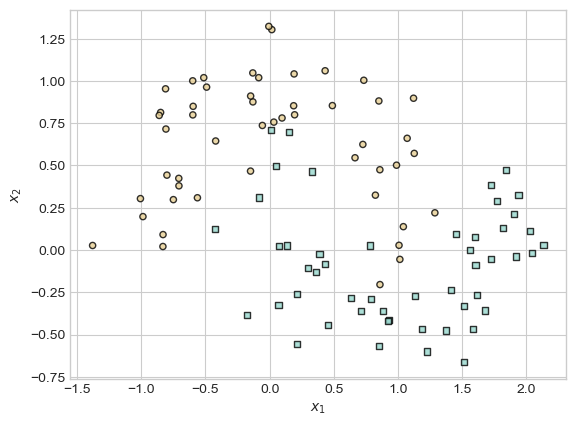

In [3]:
fig, ax = plt.subplots(1, 1)
plot_classification_data(X_train,y_train, ax)

The training loop for Torch models looks similar to training loops that we have seen for the perceptron and for logistic regression. There are a few important differences: 

1. We generally use a pre-implemented optimizer from `torch.optim`. Today we're using gradient descent. 
2. We also use a pre-implemented loss-function. Today we're using the cross-entropy loss. As you may remember, the combination of a linear model with the binary cross-entropy loss means that we are working with our good friend, logistic regression. 
3. Instead of manually computing a gradient and writing out gradient descent, instead we make the rather cryptic calls `loss.backward()` followed by `opt.step()`. As we'll soon discuss, `loss.backward()` actually handles all the gradient calculations for us (no more calculus by hand!), while `opt.step()` takes that gradient information and uses it to update the parameters. 
    - After each call of `loss.backward()`, it's necessary to call `opt.zero_grad()` in order to "zero out" the gradient information computed in the previous loop. 

In [ ]:
def train_model(model, num_steps, **kwargs):

    # define the loss function L for the linear model
    loss_fn = nn.CrossEntropyLoss()

    # instantiate an optimizer -- gradient descent today
    opt = torch.optim.SGD(model.parameters(), **kwargs)

    # collect the values of the loss in each step
    loss_train_vec = []
    loss_val_vec   = []

    for i in range(num_steps): 
        #compute scores on training data 
        s = model.score(X_train)                      # compute the scores 
        loss = loss_fn(s, y_train)                 # compute the model loss
        # loss.backward() calculates the gradient for us efficiently, automatically and without approximation 
        loss.backward()                      # auto-compute gradient
        opt.step()                           # optimizer updates params

        opt.zero_grad()                      # zero out the gradient
        

        # for tracking model progress on the training set
        loss_train_vec.append(loss.item())   
        
        # and on the validation set
        s_val = model.score(X_val)
        loss_val = loss_fn(s_val, y_val)
        loss_val_vec.append(loss_val.item())

    return loss_train_vec, loss_val_vec

Now that we have defined a model and a training loop, let's go ahead and train the model! 

In [4]:
LM = LinearModel(2, 2)
loss_train, loss_val = train_model(LM, num_steps = 1000, lr = 0.1)


NameError: name 'LinearModel' is not defined

Now that we've trained the model, let's see how we did on the training set: 

NameError: name 'loss_train' is not defined

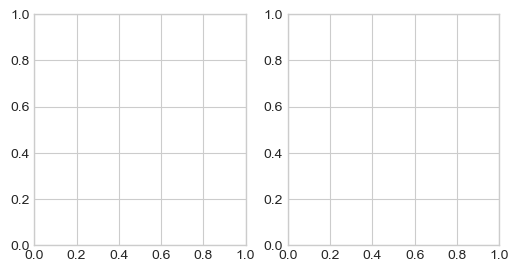

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (6, 3))
ax[0].plot(loss_train, c = "steelblue", label = "Training")
ax[0].set(xlabel = "iteration", ylabel = "loss")
plot_classification_data(X_train, y_train, ax[1], clf = LM)
plt.tight_layout()

Yep, that's logistic regression! We've fit a reasonable classifying line, but haven't captured any nonlinear trend. 

## Adding A Hidden Layer

In order to model the nonlinearity, let's add a single hidden layer to our model. 

In [6]:
from torch import nn 

class SingleHiddenLayer(nn.Module):

    def __init__(self, num_features, num_labels, num_hidden):
        """
        sets up the model infrastructure
        """
        super().__init__()
    
        self.pipeline = nn.Sequential(
            #input features has to match 
            #secong arg in nn.Linear has to match first arg in ll.Linear to allow math to be okay
            nn.Linear(num_features, num_hidden), 
            nn.ReLU(),
            nn.Linear(num_hidden, num_labels)
        )

    def score(self, x):
        """
        computes scores for each class 
        """
        return self.pipeline(x)

    def predict(self, x): 
        return self.score(x) > 0

Let's also streamline the process of fitting the model and visualizing the results. 

In [7]:
def plot_experiment(model, **kwargs):
    fig, ax = plt.subplots(1, 3, figsize = (9, 3))
    loss_train, loss_val = train_model(model, **kwargs)     
    ax[0].plot(loss_train, c = "steelblue", label = "Training")
    ax[0].plot(loss_val, c = "goldenrod", label = "Validation")
    ax[0].set(xlabel = "Iteration", ylabel = "Loss")
    ax[0].legend()
    plot_classification_data(X_train, y_train, ax[1], clf = model)    
    plot_classification_data(X_val, y_val, ax[2], clf = model, data = "Validation")    
    plt.tight_layout()

NameError: name 'train_model' is not defined

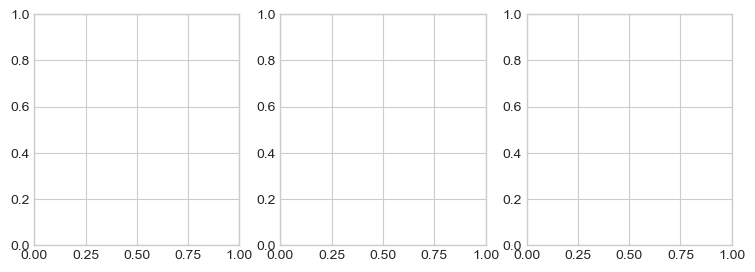

In [8]:
LM = SingleHiddenLayer(2, 2, 100)
plot_experiment(LM, num_steps = 5000, lr = 0.2)

We've been able to model a nonlinear decision boundary without explicitly constructing a feature map or using kernels. Instead, we learned a helpful feature map as part of the training process. 

[Note that omitting the `ReLU` layer in the hidden layer will result in a model that is equivalent to the linear model. This is because the composition of two linear functions is itself a linear function. Try it!]{.aside}

What if we wanted Even More Layers? We can easily do this just by adding more layers inside the pipeline. 

In [9]:
from torch import nn 

class FullyConnectedStack(nn.Module):

    def __init__(self, num_features, num_labels):
        """
        sets up the model infrastructure
        """
        super().__init__()
    
        self.pipeline = nn.Sequential(
            #we add two hidden layers
            nn.Linear(num_features, 50), #fifty hidden features
            nn.ReLU(), #ReLu that
            nn.Linear(50, 10), #hit it with another linear layer bbut collapse 50 to 10 hidden features
            nn.ReLU(), #relu that
            nn.Linear(10, num_labels)     # linear final layer that returns scores to the num of layers        
        )

    def score(self, x):
        """
        computes scores for each class 
        """
        return self.pipeline(x)

    def predict(self, x): 
        return self.score(x) > 0

As usual, adding more layers can help us model more complex patterns in the data, but also increases the risk of overfitting.

NameError: name 'train_model' is not defined

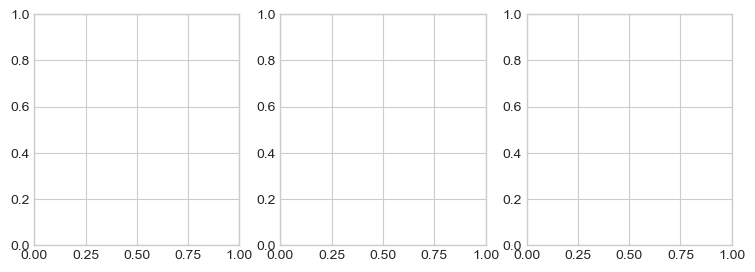

In [10]:
LM = FullyConnectedStack(2, 2)
plot_experiment(LM, num_steps = 10000, lr = 0.05, momentum = 0.8)

## Looking Ahead

So far, we have seen that a single hidden layer can help us learn nonlinear decision boundaries in data, without the need to construct handmade features or use kernel methods. However, we now have a wide range of both theoretical and practical questions ahead of us. 

- did not calculate gradient descent 

- deep learning revolution: stacking layers on top of each other, but what makes tech possible is loss.backward()

- calculates the gradient for us efficiently, automatically and without approximation 

1. Are these models still convex? Can I still use gradient descent?
2. Isn't it hard to compute gradients for these more complicated models? How does anyone keep track of all the calculus? 
3. How many layers should I use in my models? How large should the matrices be? 
4. How should I adapt my models when I am working with specific kinds of data, such as text, images, or audio?
5. How should I guard against overfitting as my models get progressively more complex? 
